In [1]:
import os
import pickle as pkl
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from functions import *
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns
from matplotlib_venn import venn2, venn3

In [2]:
proAB = pd.read_csv('../data/Proteomics/Proteomics_AB.csv')
proB = pd.read_excel('../data/Proteomics/Proteomics_B.xlsx')
gene_info = proB[list(proB.columns[0:5])]
name_dict = {proB['Accession'][i]: proB['Gene Name'][i] for i in proB.index}

# PCA of proteomics (batch B)

In [3]:
proB = proAB[['ID'] + list(proAB.columns[-12:])]; proB = proB.set_index('ID'); proB = proB.T;
genes_keep_B =  proB.columns[proB.sum(axis=0) > 0];
print( len(genes_keep_B) );
proB = proB[ genes_keep_B ];

2010


In [4]:
X = proB.iloc[:,:].values
Xstd = StandardScaler().fit_transform(X)
pca_transform = PCA(n_components=2)
X_pca = pca_transform.fit_transform( Xstd )
print(pca_transform.explained_variance_ratio_)

[0.60237455 0.17372122]


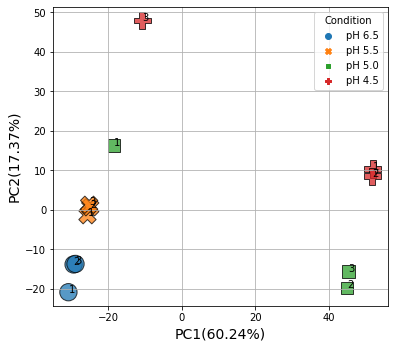

In [6]:
samples = ['pH 6.5' for i in range(3)] + ['pH 5.5' for i in range(3)] + ['pH 5.0' for i in range(3)]+['pH 4.5' for i in range(3)]
X_pca_pd = pd.DataFrame(X_pca, columns=['PC1','PC2'])
X_pca_pd['Condition'] = [x.split('-')[0] for x in samples]
fig, ax = plt.subplots(1,1,figsize=(6,5.5))
sns.scatterplot(data=X_pca_pd, x="PC1", y="PC2", hue="Condition", style="Condition", \
                s=300,linewidth=1,alpha=0.75, edgecolor='black',ax= ax)
for i in range(len(X_pca)):
    ax.text(x=X_pca[i][0],y=X_pca[i][1],s=str(int(i%3)+1) )
ax.grid()
ax.set_xlabel('PC1(60.24%)',fontsize=14);
ax.set_ylabel('PC2(17.37%)',fontsize=14);
# plt.savefig('../../../../EPS_LP/Figures/PCA_proteomics.svg',format='svg',dpi=150)

# Prepare datasets for DEG analysis

In [3]:
# outliers are replaced by average values
proB = proAB[['ID'] + list(proAB.columns[-12:])]
old_columns = list(proB.columns)
proB = proB.drop(['pH5-B1','pH4.5-B3'],axis=1)
proB['pH5-B1'] = (proB['pH5-B2'] + proB['pH5-B3'])/2;proB['pH4.5-B3'] = (proB['pH4.5-B1'] + proB['pH4.5-B2'])/2;
proB = proB[old_columns]
proB = proB.set_index('ID'); proB = proB.T;
genes_keep_B =  proB.columns[proB.sum(axis=0) > 0];
print( len(genes_keep_B) );
proB = proB[ genes_keep_B ];

2010


In [4]:
# convert m/z ratios to non-negative integers by mutiplying 1000
for k in proB.columns:
    temp = [ int(x*1000) for x in list(proB[k]) ]
    proB[k] = temp

In [5]:
meta_B = pd.DataFrame(zip(list(proB.index), [x.split('-')[0] for x in list(proB.index) ] ), columns=['sample','condition'])
meta_B = meta_B.set_index('sample')

# Single factor analysis (ref_condition = pH6.5)

In [6]:
from pydeseq2.dds import DeseqDataSet
from pydeseq2.default_inference import DefaultInference
from pydeseq2.ds import DeseqStats

In [7]:
OUTPUT_PATH = "../data/Proteomics/"
inference = DefaultInference()

In [8]:
dds_B = DeseqDataSet( counts= proB, metadata= meta_B,
    design_factors="condition", refit_cooks=True,ref_level= ["condition", "pH6.5"], inference=inference )

In [9]:
dds_B.deseq2()
print(dds_B)

Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 0.37 seconds.

Fitting dispersion trend curve...
... done in 0.10 seconds.

/home/bras5181/miniconda3/envs/pydeseq2/lib/python3.8/site-packages/anndata/_core/views.py:113: RuntimeWarning: invalid value encountered in log
  results = super().__array_ufunc__(
Fitting MAP dispersions...


AnnData object with n_obs × n_vars = 12 × 2010
    obs: 'condition'
    uns: 'trend_coeffs', '_squared_logres', 'prior_disp_var'
    obsm: 'design_matrix', 'size_factors', 'replaceable'
    varm: 'non_zero', '_MoM_dispersions', 'genewise_dispersions', '_genewise_converged', '_normed_means', 'fitted_dispersions', 'MAP_dispersions', '_MAP_converged', 'dispersions', '_outlier_genes', 'LFC', '_LFC_converged', 'replaced'
    layers: 'normed_counts', '_mu_hat', '_mu_LFC', '_hat_diagonals', 'cooks'


... done in 1.26 seconds.

/home/bras5181/miniconda3/envs/pydeseq2/lib/python3.8/site-packages/pydeseq2/dds.py:706: RuntimeWarning: invalid value encountered in log
  self.varm["_outlier_genes"] = np.log(self.varm["genewise_dispersions"]) > np.log(
Fitting LFCs...
... done in 0.19 seconds.

Refitting 0 outliers.



# Statistical analysis 

In [12]:
resB_5d5vs6d5 = DeseqStats(dds_B,contrast= ['condition', 'pH5.5', 'pH6.5'], inference=inference)
resB_5vs6d5 = DeseqStats(dds_B,contrast= ['condition', 'pH5', 'pH6.5'], inference=inference)
resB_4d5vs6d5 = DeseqStats(dds_B, contrast= ['condition', 'pH4.5', 'pH6.5'],inference=inference)

In [13]:
resB_5d5vs6d5.summary()
resB_5vs6d5.summary()
resB_4d5vs6d5.summary()

Running Wald tests...
... done in 0.12 seconds.

Running Wald tests...


Log2 fold change & Wald test p-value: condition pH5.5 vs pH6.5
           baseMean  log2FoldChange     lfcSE       stat        pvalue  \
ID                                                                       
Q88XZ2  1074.522847       -0.017841  0.035771  -0.498762  6.179472e-01   
F9UQ80  1014.410706       -0.077065  0.035832  -2.150701  3.149981e-02   
Q88XZ3  1071.113402        0.048334  0.036642   1.319090  1.871391e-01   
Q88YM5  1109.124642       -0.580815  0.049967 -11.624001  3.112116e-31   
F9UPM3  1070.777967       -0.080855  0.033904  -2.384861  1.708557e-02   
...             ...             ...       ...        ...           ...   
F9US85  2707.763793        0.008290  2.746559   0.003018  9.975916e-01   
F9USP2  2622.947506        0.008291  2.747463   0.003018  9.975924e-01   
F9UP32  2708.039982        0.008290  2.746540   0.003019  9.975916e-01   
F9UTG7  2847.026004        0.008290  2.766848   0.002996  9.976094e-01   
F9UQ73  2704.856405        0.008290  2.747443   0

... done in 0.11 seconds.

Running Wald tests...
... done in 0.11 seconds.



In [14]:
# "../data/Proteomics/"
# resB_5vs6d5.results_df.to_csv("../data/Proteomics/deg_5vs6d5_B.csv")
# resB_5d5vs6d5.results_df.to_csv("../data/Proteomics/deg_5d5vs6d5_B.csv")
# resB_4d5vs6d5.results_df.to_csv("../data/Proteomics/deg_4d5vs6d5_B.csv")

# Volcano plots

In [9]:
deg_5d5vs6d5_B = pd.read_csv("../data/Proteomics/deg_5d5vs6d5_B.csv")
deg_5vs6d5_B = pd.read_csv("../data/Proteomics/deg_5vs6d5_B.csv")
deg_4d5vs6d5_B = pd.read_csv("../data/Proteomics/deg_4d5vs6d5_B.csv")

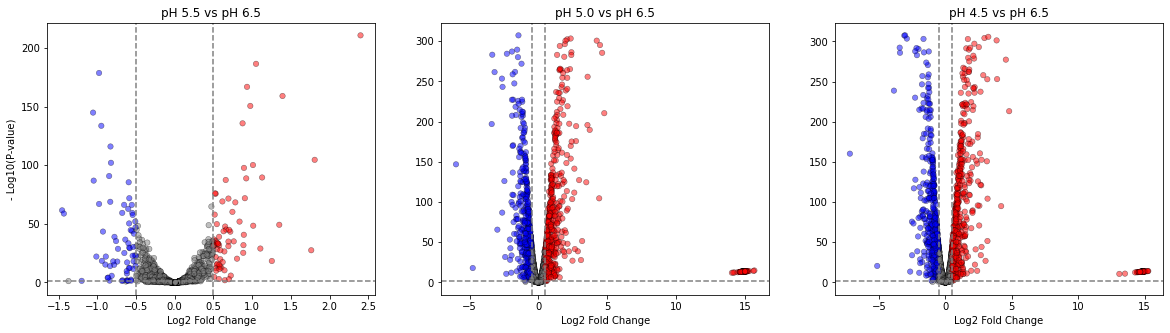

In [13]:
fig, axs = plt.subplots(1,3,figsize=(20,5))
volcano( deg_5d5vs6d5_B, 'log2FoldChange', 'padj', 0.5, 0.05, 30, axs[0])
volcano( deg_5vs6d5_B, 'log2FoldChange', 'padj', 0.5, 0.05, 30, axs[1])
volcano( deg_4d5vs6d5_B, 'log2FoldChange', 'padj', 0.5, 0.05, 30, axs[2])

for ax in axs:
    ax.set_xlabel('Log2 Fold Change')
axs[0].set_ylabel('- Log10(P-value)')
axs[0].set_title('pH 5.5 vs pH 6.5')
axs[1].set_title('pH 5.0 vs pH 6.5')
axs[2].set_title('pH 4.5 vs pH 6.5')
# plt.savefig('../../../../EPS_LP/Figures/volcano_proteomics.svg',format='svg',dpi=150)

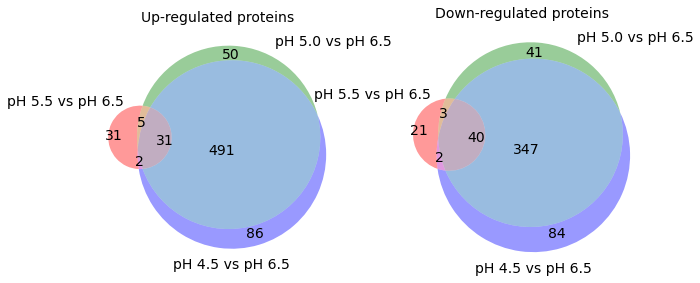

In [15]:
fig, axs = plt.subplots(1,2,figsize=(10,6))
up_dict, down_dict = {},{}
labels = ['pH 5.5 vs pH 6.5','pH 5.0 vs pH 6.5','pH 4.5 vs pH 6.5']
genes_5d5vs6d5_B = get_deg( deg_5d5vs6d5_B, 'log2FoldChange', 'padj', 0.5, 0.05 )
genes_5vs6d5_B = get_deg( deg_5vs6d5_B, 'log2FoldChange', 'padj', 0.5, 0.05 )
genes_4d5vs6d5_B = get_deg( deg_4d5vs6d5_B, 'log2FoldChange', 'padj', 0.5, 0.05 )

up_dict['pH5.5 vs pH6.5'] = genes_5d5vs6d5_B['up'];up_dict['pH5 vs pH6.5'] = genes_5vs6d5_B['up'];
up_dict['pH4.5 vs pH6.5'] = genes_4d5vs6d5_B['up']
down_dict['pH5.5 vs pH6.5'] = genes_5d5vs6d5_B['down'];down_dict['pH5 vs pH6.5'] = genes_5vs6d5_B['down'];
down_dict['pH4.5 vs pH6.5'] = genes_4d5vs6d5_B['down']

plot1 = venn3([set(up_dict['pH5.5 vs pH6.5']),set(up_dict['pH5 vs pH6.5']),set(up_dict['pH4.5 vs pH6.5'])],\
      set_labels=labels ,ax = axs[0])
plot2 = venn3([set(down_dict['pH5.5 vs pH6.5']),set(down_dict['pH5 vs pH6.5']),set(down_dict['pH4.5 vs pH6.5'])],\
      set_labels=labels ,ax = axs[1])
axs[0].set_title('Up-regulated proteins', fontsize=14);
axs[1].set_title('Down-regulated proteins', fontsize=14);
for text in plot1.set_labels:
    text.set_fontsize(14)
for text in plot1.subset_labels:
    text.set_fontsize(14)
for text in plot2.set_labels:
    text.set_fontsize(14)
for text in plot2.subset_labels:
    text.set_fontsize(14)
# plt.savefig('../../../../EPS_LP/Figures/venn_deg.svg',format='svg',dpi=150)

# KEGG Pathway enrichment analysis

In [20]:
acid_up = list( set(genes_5vs6d5_B['up']).intersection(set( genes_4d5vs6d5_B['up'])) )
acid_down = list( set(genes_5vs6d5_B['down']).intersection(set( genes_4d5vs6d5_B['down'])) )
kegg_annot = pd.read_excel('../data/Proteomics/All_Proteins_KEGG_query2map.xlsx')

In [22]:
abcT_up, abcT_down = [],[]
for protein in acid_up:
    temp_pd = kegg_annot[kegg_annot['Protein_ID']==protein][['Protein_ID','Map_Name']].dropna()
    if len(temp_pd.index)<1:
        continue
    elif 'ABC transporters' in list(temp_pd['Map_Name'])[0]:
        abcT_up.append(protein)
for protein in acid_down:
    temp_pd = kegg_annot[kegg_annot['Protein_ID']==protein][['Protein_ID','Map_Name']].dropna()
    if len(temp_pd.index)<1:
        continue
    elif 'ABC transporters' in list(temp_pd['Map_Name'])[0]:
        abcT_down.append(protein)

In [6]:
def pathway_enrich(gene_set, id_col, annot_col, annotation):
    enrich = {}
    un_annot = []
    for gene in gene_set:
        temp_pd = (annotation[annotation[id_col]==gene]).reset_index().drop(['index'],axis=1)
        temp_pd = (temp_pd[[id_col,annot_col ]]).dropna()
        if len(temp_pd.index)<1:
            un_annot.append(gene)
        else:
            for pathway in list(temp_pd[annot_col])[0].split(';'):
                pathway = pathway.strip()
                if pathway in enrich:
                    enrich[pathway] +=1
                else:
                    enrich[pathway] = 1
    enrich_pd = pd.DataFrame(zip(enrich.keys(),enrich.values()), columns=['Pathway','Count'])
    enrich_pd = enrich_pd.sort_values(by=['Count'], ascending=False).reset_index().drop(['index'],axis=1)
    return enrich_pd, un_annot

In [7]:
def barh_enrich(table, top_n, color, ax):
    names, values = [],[]
    for i in range(min(top_n, len(table.index)) ):
        names.append(table['Pathway'][i])
        values.append(table['Count'][i])
    ax.barh( names, values, color=color )

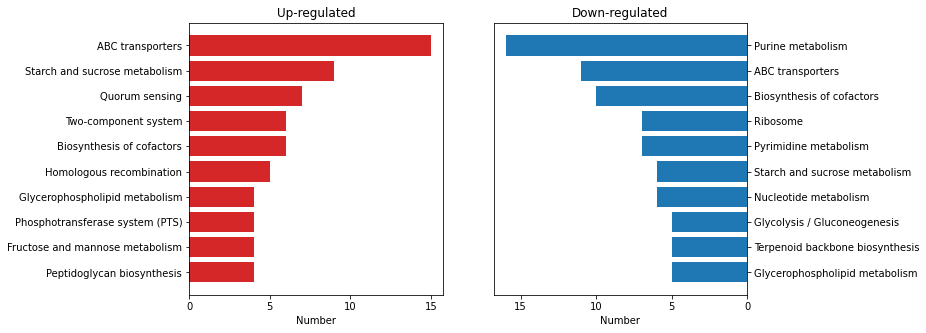

In [10]:
fig, axs = plt.subplots(1,2, figsize=(10,5))
table_up,_= pathway_enrich( acid_up, 'Protein_ID', 'Map_Name', kegg_annot)
table_down,_ = pathway_enrich( acid_down,'Protein_ID', 'Map_Name', kegg_annot)

barh_enrich(table_up, 10, 'tab:red', axs[0])
barh_enrich(table_down, 10, 'tab:blue',axs[1])
axs[1].invert_xaxis();axs[1].invert_yaxis();axs[0].invert_yaxis()
axs[1].yaxis.tick_right()
axs[0].set_title('Up-regulated')
axs[1].set_title('Down-regulated')
axs[0].set_xlabel('Number')
axs[1].set_xlabel('Number')
for ax in axs:
    ax.set_xticks([0,5,10,15])
# plt.savefig('../../../../EPS_LP/Figures/kegg_enrich.svg',format='svg',dpi=150)

# Subcellular location enrichment analysis

In [11]:
subloc_annot = pd.read_excel('../data/Proteomics/All_Proteins_SubLoc.xlsx')
sub_locs =[]
locations = ['Cell membrane','Membrane','cell wall','Cell envelope','Secreted','Cytoplasm']
for subloc in list(subloc_annot.SubLocations):
    temp_locs = []
    for loc_type in locations:
        if loc_type in subloc:
            if loc_type == 'Cell membrane':
                temp_locs.append('Membrane')
            elif loc_type == 'cell wall':
                temp_locs.append('Cell wall')
            else:
                temp_locs.append(loc_type)
    sub_locs.append(';'.join(set(temp_locs)) )
subloc_annot['Subloc_annot'] = sub_locs
subloc_annot.head()

,Protein ID,SubLocations,Subloc_annot
0,Q88YM5,Cytoplasm,Cytoplasm
1,Q88XY8,Cytoplasm,Cytoplasm
2,Q88YL7,Cell membrane;Peripheral membrane protein;Cyto...,Cytoplasm;Membrane
3,Q88UX7,Cytoplasm,Cytoplasm
4,Q88V89,Cytoplasm,Cytoplasm


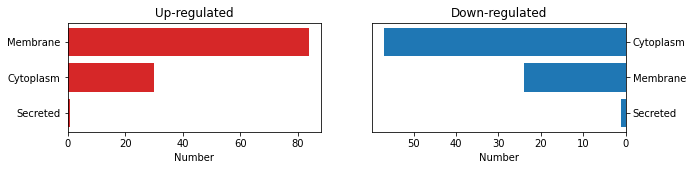

In [13]:
fig, axs = plt.subplots(1,2, figsize=(10,2))
table_up,_= pathway_enrich( acid_up, 'Protein ID', 'Subloc_annot', subloc_annot)
table_down,_ = pathway_enrich( acid_down,'Protein ID', 'Subloc_annot', subloc_annot)
barh_enrich(table_up, 10, 'tab:red', axs[0])
barh_enrich(table_down, 10, 'tab:blue',axs[1])
axs[1].invert_xaxis();axs[1].invert_yaxis();axs[0].invert_yaxis()
axs[1].yaxis.tick_right()
axs[0].set_title('Up-regulated')
axs[1].set_title('Down-regulated')
axs[0].set_xlabel('Number')
axs[1].set_xlabel('Number')
# plt.savefig('../../../../EPS_LP/Figures/subloc_enrich.svg',format='svg',dpi=150)

# Regulon analysis

In [14]:
regulons = load_pickle('../data/Proteomics/lpwcfs1_regulons.pkl')
uniprot_info = pd.read_csv('../data/Proteomics/uniprotkb_taxonomy_id_220668.tsv',sep='\t')
regulators, gene_ids = [],[]
for k in regulons.keys():
    gene_ids += regulons[k]
    regulators += [ k for i in range(len(regulons[k])) ]
trn = pd.DataFrame(zip(regulators,gene_ids), columns=['regulator','gene_id'])

In [15]:
locus_tags = list(np.unique(trn['gene_id']))
RFs, uni_ids = [],[]
for gid in locus_tags:
    rf_list = list(trn[trn['gene_id']==gid]['regulator'])
    if len(rf_list) > 1:
        RFs.append(';'.join(rf_list))
    else:
        RFs.append(rf_list[0])
    protein_id = list(uniprot_info[uniprot_info['Gene Names (ordered locus)']==gid]['Entry'])[0]
    uni_ids.append( protein_id )
regulon_info = pd.DataFrame(zip(uni_ids,locus_tags,RFs), columns=['Protein_ID','locus_tag','RFs'])

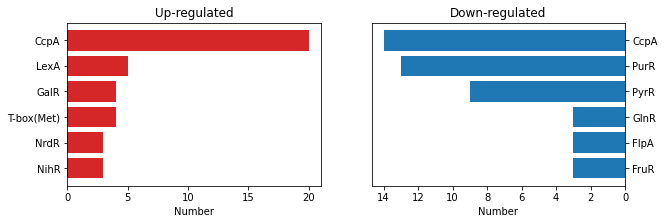

In [17]:
fig, axs = plt.subplots(1,2, figsize=(10,3))
table_up,_= pathway_enrich( acid_up, 'Protein_ID', 'RFs', regulon_info)
table_down,_ = pathway_enrich( acid_down,'Protein_ID', 'RFs', regulon_info)

barh_enrich(table_up, 6, 'tab:red', axs[0])
barh_enrich(table_down, 6, 'tab:blue',axs[1])

axs[1].invert_xaxis();axs[1].invert_yaxis();axs[0].invert_yaxis()
axs[1].yaxis.tick_right()
axs[0].set_title('Up-regulated')
axs[1].set_title('Down-regulated')
axs[0].set_xlabel('Number')
axs[1].set_xlabel('Number')
# plt.savefig('../../../../EPS_LP/Figures/regulon_enrich.svg',format='svg',dpi=150)

# Expression of acid active TFs

In [14]:
uniprot_info = pd.read_csv('../data/Proteomics/uniprotkb_taxonomy_id_220668.tsv',sep='\t')
TFs = {}
ffile = open('../data/Proteomics/Regulons_Lplantarum_WCFS1.txt', "rt")
lines = ffile.readlines()
ffile.close()
for line in lines:
    if ('#' in line) and ('lp_' in line):
        RF = ((line.split(' - ')[1]).split(':')[0]).strip()
        genes = ((line.split(' - ')[1]).split(':')[1]).strip().split(', ')
        for gene in genes:
            TFs[gene] = RF
TFs['lp_3247'] = 'Fur'; TFs['lp_2704'] = 'PyrR'; TFs['lp_2772'] = 'McbR'
TF_proteins=[]
for k in TFs.keys():
    TF_proteins.append( list(uniprot_info[uniprot_info['Gene Names (ordered locus)']==k]['Entry'])[0] ) 

In [16]:
TF_pd = pd.DataFrame(zip(TFs.keys(), TFs.values(),TF_proteins ), columns=['locus_tag','TF','Protein'])

In [28]:
TF_up=set(TF_pd[TF_pd.Protein.isin(acid_up)]['TF'])
print(TF_up)
TF_down=set( TF_pd[TF_pd.Protein.isin(acid_down)]['TF'] )
print(TF_down)
All_TFs = set( np.unique(TF_pd['TF']) )

{'MtaR', 'MtlR', 'FlrR', 'MdxR', 'NihR', 'BirA', 'MleR', 'DeoR'}
{'NagR', 'Rex', 'TreR', 'PurR', 'NiaR', 'RbsR', 'ArgR', 'GlnR', 'Fur', 'FlpA', 'FruR', 'YtrA', 'PyrR'}


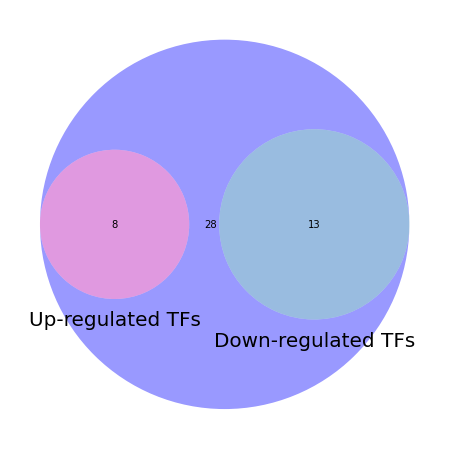

In [34]:
fig, ax = plt.subplots(1,1,figsize=(8,8))
plot = venn3([TF_up,TF_down,All_TFs],set_labels=['Up-regulated TFs', 'Down-regulated TFs', ''] ,ax = ax)
for text in plot.set_labels:
    text.set_fontsize(20)
# plt.savefig('../../../../EPS_LP/Figures/TF_venn.svg',format='svg',dpi=150)